In [1]:
import os
import argparse
import glob
import numpy as np
import pickle
import json
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from utils import l1_inpainting
from projection_utils import Projection
from data_parser import read_keypoints

INFO - 2022-05-30 19:05:29,873 - acceleratesupport - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [2]:
# _____________ read frames _____________
data_root = '../quantitative/recordings'
sequence_id = 'vicon_03301_01'
save_root = '../quantitative/proximity'

rgb_list = glob.glob(os.path.join(data_root, sequence_id, 'Color/*.jpg'))
rgb_list.sort()
# rgb_list[-1][-33:-30]
n_frame = int(rgb_list[-1][-33:-30])  # total frame number
# rgb_list
n_frame
# rgb_list[-1][-34:-4]
scene_point_cloud = o3d.io.read_point_cloud(os.path.join("../quantitative", "scenes", "vicon.ply"))
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(scene_point_cloud)
vis.run()
vis.destroy_window()

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


: 

In [36]:
# _____________ init _____________
projection = Projection("../quantitative/calibration")
MAX_DEPTH = 20.0
depth_scale = 1e3       # TODO: determine depth_scale
point_cloud = o3d.geometry.PointCloud()
vis = o3d.visualization.Visualizer()
h_rgb = 1080
w_rgb = 1920
h_depth = 424
w_depth = 512

curr_frame = rgb_list[6]

# output all results
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# h_depth * w_depth

217088

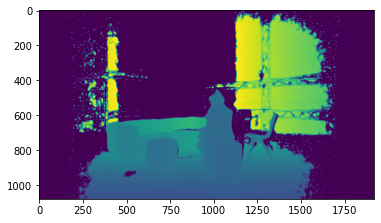

In [15]:
# _____________ read depth _____________
depth_img = cv2.imread(os.path.join(data_root, sequence_id, 'Depth/' + curr_frame[-34:-4] + '.png'), flags=-1).astype(float)
depth_raw = depth_img.copy()
depth_img /= 8.0
depth_img /= 1000.0
depth_img = cv2.flip(depth_img, 1)
depth_raw = cv2.flip(depth_raw, 1)
depth_aligned = projection.align_depth2color(depth_img, depth_raw)

# _____________ read rgb _____________
color_img = cv2.imread(curr_frame)
color_img = cv2.flip(color_img, 1)
color_aligned = projection.align_color2depth(depth_raw, color_img)

# _____________ scale depth _____________
# TODO: @Di & Benji, ask Siwei how to find a proper scaling factor
depth_aligned = depth_aligned.astype(float)
# min = np.min(depth_aligned[depth_aligned > 0])
# depth_aligned = depth_aligned - min
# MAX_DEPTH = np.max(depth_aligned)
# depth_aligned[depth_aligned > MAX_DEPTH] = 0
# depth_aligned /= 8.0
# depth_aligned /= 1000.0
# depth_inpainted = l1_inpainting(depth_aligned, depth_aligned == 0, maxIter=300)
depth_aligned = l1_inpainting(depth_aligned, depth_aligned == 0, maxIter=300)

plt.imshow(color_aligned)
plt.imshow(color_img)
plt.imshow(depth_aligned)
# plt.colorbar()

In [17]:
depth_raw.shape
depth_aligned.shape
color_img.shape
color_aligned.shape

(424, 512)

(1080, 1920)

(1080, 1920, 3)

(424, 512, 3)

In [33]:
# _____________ create point cloud (h_rgb, w_rgb)_____________
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image((np.asarray(color_img)).astype(np.uint8)),
    o3d.geometry.Image((np.asarray(depth_aligned)).astype(np.float32)),
    depth_trunc=MAX_DEPTH,
    convert_rgb_to_intensity=False,
)
with open('../quantitative/calibration/Color.json') as f:
        camera_rgb = json.load(f)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(w_depth, h_depth, camera_rgb['f'][0], camera_rgb['f'][1], camera_rgb['c'][0], camera_rgb['c'][1]),
)  # cam coordinate

scene_verts = np.asarray(pcd.points)     # [h*w, 3], coordinate of each pixel in the depth map
scene_verts_aug = np.hstack([scene_verts, np.ones([scene_verts.shape[0], 1])])
with open('../quantitative/cam2world/vicon.json') as f:
        camera_ext = json.load(f)
cam_extr_ref = np.linalg.inv(camera_ext)
scene_verts = scene_verts_aug.dot(cam_extr_ref)[:, :3]      # camera to world transformation
pcd.points = o3d.utility.Vector3dVector(scene_verts) # world coordinate
# o3d.visualization.draw_geometries([pcd])
# np.asarray(pcd.points).shape

(1269365, 3)

In [19]:
# _____________ read keypoints and skeleton _____________
keyp_tuple = read_keypoints('../quantitative/keypoints/' + sequence_id + '/' + rgb_list[5][-34:-4] + '_keypoints.json', use_hands=False, use_face=False, use_face_contour=False)
keypoints = np.stack(keyp_tuple.keypoints)
keypoints.shape
# mask.shape[1]

(1, 25, 3)

In [20]:
# _____________ read keypoints and skeleton (pickle) _____________
path = "../quantitative/fittings/mosh/vicon_03301_01/results/s001_frame_00001__00.00.00.023/000.pkl"
with open(path, 'rb') as file:
    smpl = pickle.load(file, encoding='latin1')
smpl

{'transl': array([[-0.6994415 , -0.31427762,  0.9848179 ]], dtype=float32),
 'num_pca_comps': 12,
 'beta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'jaw_pose': array([[0., 0., 0.]], dtype=float32),
 'body_pose': array([[ 0.0590809 ,  0.05310533,  0.09144919,  0.06638564, -0.03938352,
         -0.03405466,  0.04605372,  0.03528766, -0.00767644, -0.01093746,
         -0.04850643, -0.04170513, -0.00294363,  0.09496448,  0.04342466,
          0.04438157, -0.05772606,  0.02723523,  0.02083636,  0.204744  ,
         -0.04182123,  0.00783336, -0.13903025,  0.09834542,  0.03948856,
         -0.01690864,  0.0097099 ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.11294897,  0.02547551,
          0.01097451,  0.05551571, -0.02713786, -0.38216677,  0.06716956,
          0.01517425,  0.40331653,  0.11045438, -0.00737314,  0.05088175,
          0.0304325 , -0.12942097, -0.5711655 ,  0.06874575,  0.0668682 ,
          0.5659935 ,  0.

In [21]:
smplx_model_path='../models_smplx_v1_1/models/smplx/SMPLX_NEUTRAL2.pkl'
with open(smplx_model_path, 'rb') as file:
    out = pickle.load(file, encoding='latini')

In [22]:
smplx_model_path='../models_smplx_v1_1/models/smplx/SMPLX_NEUTRAL2.pkl'
with open(smplx_model_path, 'wb') as file:
    pickle.dump(out, file)

In [23]:
import torch

# specify device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


print('-- pytorch version={}'.format(torch.__version__))
print('-- device={}'.format(device))

smplx_model_path='../models_smplx_v1_1/models/smplx/SMPLX_NEUTRAL2.pkl'

import smplx  # SMPL-X; pip install smplx

def get_smplx_model(gender, device):
    body_model_path = smplx_model_path
    body_model = smplx.create(body_model_path, 
                          model_type='smplx',        ## smpl, smpl+h, or smplx?
                          gender=gender, ext='npz',  ## file format 
                          num_pca_comps=12,          ## MANO hand pose pca component
                          create_global_orient=True, 
                          create_body_pose=True,
                          create_betas=True,
                          create_left_hand_pose=True,
                          create_right_hand_pose=True,
                          create_expression=True, 
                          create_jaw_pose=True,
                          create_leye_pose=True,
                          create_reye_pose=True,
                          create_transl=True,
                          batch_size=1               ## how many bodies in a batch?
                          )
    body_model.eval()
    return body_model

smplx_neutral = get_smplx_model(gender='neutral', device=device)


def draw_bodies(gender, betas, thetas):
    bm = smplx_neutral


    ## read verts and face from smplx model
    params = {'betas': betas,
              'body_pose': thetas
              }


    verts = bm(return_verts=True, **params).vertices.detach().cpu().numpy()[0]
    faces = bm.faces

    ## put verts and face into open3d, and compute surface normal
    coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
    body = o3d.geometry.TriangleMesh()
    body.vertices = o3d.utility.Vector3dVector(verts)
    body.triangles = o3d.utility.Vector3iVector(faces)
    body.vertex_normals = o3d.utility.Vector3dVector([])
    body.triangle_normals = o3d.utility.Vector3dVector([])
    body.compute_vertex_normals()
    o3d.visualization.draw_geometries([body, coord])
    
    return None


-- pytorch version=1.10.2
-- device=cpu


In [24]:
data = smpl
betas = torch.Tensor(data['beta']).reshape(1, -1)
body_pose = torch.Tensor(data['body_pose'])
global_orient= torch.Tensor(data['global_orient'])
transl=torch.Tensor(data['transl'])
out = smplx_neutral(return_joints=True, betas=betas, body_pose=body_pose, global_orient=global_orient, transl=transl)
joints = out.joints[:, :21].squeeze()
joint_locations = (joints)
body_joints_3d = (out.vertices.detach().cpu().numpy().squeeze())

In [25]:
body_joints_3d

array([[-0.64845455, -0.6978891 ,  1.6229868 ],
       [-0.6453289 , -0.70073915,  1.6220896 ],
       [-0.64521587, -0.701429  ,  1.6235468 ],
       ...,
       [-0.7683206 , -0.69977   ,  1.63098   ],
       [-0.7660532 , -0.7000109 ,  1.6318812 ],
       [-0.76385707, -0.70072234,  1.6327178 ]], dtype=float32)

In [32]:
LIMBS = [
(0, 1),  # head_center -> neck
(1, 2),  # neck -> right_clavicle
(2, 3),  # right_clavicle -> right_shoulder
(3, 4),  # right_shoulder -> right_elbow
(4, 5),  # right_elbow -> right_wrist
(1, 6),  # neck -> left_clavicle
(6, 7),  # left_clavicle -> left_shoulder
(7, 8),  # left_shoulder -> left_elbow
(8, 9),  # left_elbow -> left_wrist
(1, 10),  # neck -> spine0
(10, 11),  # spine0 -> spine1
(11, 12),  # spine1 -> spine2
(12, 13),  # spine2 -> spine3
(13, 14),  # spine3 -> spine4
(14, 15),  # spine4 -> right_hip
(15, 16),  # right_hip -> right_knee
(16, 17),  # right_knee -> right_ankle
(14, 18),  # spine4 -> left_hip
(18, 19),  # left_hip -> left_knee
(19, 20),  # left_knee -> left_ankle
]
np.asarray(scan_dict['points']).shape

(11343, 3)

In [35]:
A = body_joints_3d[np.asarray(LIMBS)[:, 0]]  # [n_limb, 3]
B = body_joints_3d[np.asarray(LIMBS)[:, 1]]  # [n_limb, 3]
# n_pt = np.asarray(pcd.points).shape[0]
n_pt = np.asarray(scan_dict['points']).shape[0]
n_limb = A.shape[0]

A = np.tile(A, (n_pt, 1)).reshape(n_pt*n_limb, 3)  # [n_pt, n_limb, 3], n_pt=n_bps=scene_verts.shape[0]
B = np.tile(B, (n_pt, 1)).reshape(n_pt*n_limb, 3)
# P = np.tile(np.asarray(pcd.points), n_limb).reshape(n_pt*n_limb, 3)
P = np.tile(np.asarray(scan_dict['points']), n_limb).reshape(n_pt*n_limb, 3)

AB = B - A
AP = P - A
BP = P - B

temp_1 = np.multiply(AB, AP).sum(axis=-1)  # [n_pt, n_limb]
temp_2 = np.multiply(-AB, BP).sum(axis=-1)  # [n_pt, n_limb]
mask_1 = np.where(temp_1 <= 0)[0]   # angle between AB and AP >= 90
mask_2 = np.where((temp_1 > 0) * (temp_2 <= 0))[0]  # angle between AB and AP < 90 and angle between BA and BP >= 90
mask_3 = np.where((temp_1 > 0) * (temp_2 > 0))[0]   # angle between AB and AP < 90 and angle between BA and BP < 90
if len(mask_1) + len(mask_2) + len(mask_3) != n_pt*n_limb:
    print('[distance calculation] num of verts does not match!')

dist_1 = np.sqrt(np.sum((P[mask_1]-A[mask_1])**2, axis=-1))  # [n_mask_1]
dist_2 = np.sqrt(np.sum((P[mask_2]-B[mask_2])**2, axis=-1))  # [n_mask_2]

x = np.multiply(AB[mask_3], AP[mask_3]).sum(axis=-1) / np.multiply(AB[mask_3], AB[mask_3]).sum(axis=-1)  # [n_mask_3]
x = x.repeat(3).reshape(-1,3)
C = x * AB[mask_3] + A[mask_3]  # C: [n_mask_3, 3], the projected point of P on line segment AB
dist_3 = np.sqrt(np.sum((P[mask_3]-C)**2, axis=-1))  # n_mask_3

dist = np.zeros(n_pt*n_limb)
dist[mask_1] = dist_1
dist[mask_2] = dist_2
dist[mask_3] = dist_3
dist = dist.reshape(n_pt, n_limb)  # [n_pt, n_limb], distance from each point in scene verts to each limb
body_bps = np.min(dist, axis=-1)   # [n_pt]
body_bps.shape

(11343,)

In [27]:
curr_frame = rgb_list[5]
human_mask = cv2.imread(os.path.join(data_root, sequence_id, 'BodyIndexColor/' + curr_frame[-34:-4] + '.png'), cv2.IMREAD_GRAYSCALE)
h = human_mask.shape[0]
w = human_mask.shape[1]
human_mask =np.flip(human_mask, axis=1)
human_mask = human_mask.reshape(h*w)
human_mask_ind = np.where(human_mask == 0)[0]

depth_mask_ind = np.where(depth_aligned.flatten() == 0)[0]
# where we have points in the point cloud
depth_nomask_ind = np.asarray(list(set(range(h*w))-set(depth_mask_ind)))  # indices of nonmasked pixels
# TODO set sky mask where depth_aligned > MAX_DEPTH.
depth_mask_sky_ind = ((depth_aligned.flatten() == 0) * (human_mask==False)).reshape(h*w)  # indices of sky

depth_mask_ind.shape
depth_nomask_ind.shape
np.sum(depth_aligned == 0)

(0,)

(2073600,)

0

In [22]:
#
# nomask = (mask == 255)
# mask = (nomask == False)
# mask_ind = np.where(mask == True)[0]
# nomask_ind = np.asarray(list(set(range(h*w))-set(mask_ind))).astype(int)
# # mask_ind.shape
# nomask_ind.shape
# # mask_ind
body_bps_full = np.zeros([h * w])
# body_bps_full[nomask_ind]
# body_bps_full
body_bps.shape
depth_nomask_ind.shape
body_bps_full.shape

(1992278,)

(2073600,)

(2073600,)

(array([7.910000e+02, 8.157000e+03, 8.293000e+03, 2.942700e+04,
        5.856900e+04, 1.289810e+05, 1.457789e+06, 2.780710e+05,
        2.218500e+04, 1.500000e+01]),
 array([1.78344418, 1.78435731, 1.78527044, 1.78618357, 1.7870967 ,
        1.78800983, 1.78892296, 1.78983609, 1.79074922, 1.79166235,
        1.79257548]),
 <BarContainer object of 10 artists>)

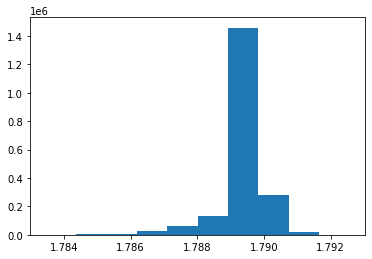

In [23]:
plt.hist(body_bps)

In [24]:
########### back to image plane, visualize bps feature map ###########
# print(cur_frame, cur_frame_N)
body_bps_full[depth_nomask_ind] = body_bps
body_bps_full[depth_mask_ind] = 1.8         # set masked pixels to 0
# body_bps_full[human_mask_ind] = 0.0
body_bps_full = body_bps_full.reshape((h, w))  # body bps feature map, [h, w]
body_bps_full = body_bps_full.astype(np.float32)
# np.save('{}/seq_{:04d}_fr_{:05d}.npy'.format(save_root, '/proximity/', curr_frame[-34:-4]), body_bps_full)
# np.save(save_root + '/first.png', body_bps_full)

plt.imshow(body_bps_full, cmap='plasma')
plt.colorbar()
plt.show()

# body_bps_full[body_bps_full>10] = 10
# fig = plt.imshow(body_bps_full, cmap='plasma', vmin=0, vmax=5)
# plt.axis('off')
# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
# plt.imsave(save_root + '/first.png', body_bps_full, cmap='plasma')
# # plt.show()

ValueError: shape mismatch: value array of shape (1992278,) could not be broadcast to indexing result of shape (2073600,)

(array([6.38000e+02, 2.05100e+03, 7.93500e+03, 5.01190e+04, 1.96140e+04,
        3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.99324e+06]),
 array([1.7834498, 1.7851048, 1.7867599, 1.7884148, 1.7900698, 1.7917249,
        1.7933799, 1.7950349, 1.7966899, 1.798345 , 1.8      ],
       dtype=float32),
 <BarContainer object of 10 artists>)

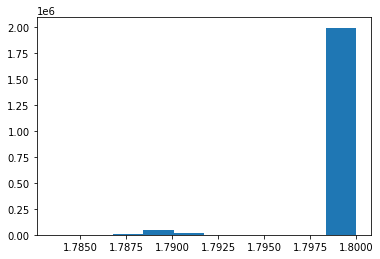

In [ ]:
plt.hist(body_bps_full.flatten())